# HLCV Project

In [ ]:
Name = "Luisa Danalachi"
Matriculation_Number = "7022909"

Name = "Victor Martinez Palomares"
Matriculation_Number = "7021729"

Name = "Soham Roy"
Matriculation_Number = "7028704"

In [3]:
 from google.colab import drive
 drive.mount('/content/drive')

 !mkdir ./datasets
 !mkdir ./datasets/lyme_dataset
 !cp -r drive/MyDrive/archive.zip ./datasets
 !unzip -q -o "./datasets/archive.zip" -d "./datasets/lyme_dataset"





# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir ./datasets
# !mkdir ./datasets/lyme_dataset
# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV_project/datasets/lyme_dataset.zip ./datasets
# !unzip -q -o "./datasets/lyme_dataset.zip" -d "./datasets/lyme_dataset"

# '''
# !mkdir ./resources

# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources
# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources

# '''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/lyme_dataset’: File exists


# Imports

In [4]:
import os
import glob
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.utils.data as data
import pandas as pd
import os
import shutil
from glob import glob
import pandas as pd
import os
import shutil

### Params

In [5]:
IMAGE_SIZE = 256
EPOCHS = 120
BATCH = 4
LR = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


Using device: cuda


# Define data augmentations

In [6]:
data_aug_transforms = []

data_aug_transforms.append(transforms.RandomRotation([-90, 90]) ) 
data_aug_transforms.append( transforms.RandomHorizontalFlip() )
data_aug_transforms.append(transforms.ColorJitter(brightness = 0.2)) 

norm_transforms = [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                   transforms.ToTensor(), 
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

train_transforms = transforms.Compose(data_aug_transforms + norm_transforms)

# Add Compose
test_transforms =transforms.Compose(norm_transforms) 

# Load Lyme DS

In [7]:
#Load Lyme
#lyme_train_data_path = "./datasets/Lyme/Train/Train_2_Cases"
#lyme_test_data_path = "./datasets/Lyme/Validation/Validation_2_Cases"
lyme_train_data_path = "./datasets/lyme_dataset/RashData/Train/Train_2_Cases"
lyme_test_data_path = "./datasets/lyme_dataset/RashData/Validation/Validation_2_Cases"
# ImageFolder is a generic data loader where the images are arranged in multiple folders

#Load TRAIN
lyme_train_data = torchvision.datasets.ImageFolder(root=lyme_train_data_path, transform=train_transforms)
lyme_train_data_loader = data.DataLoader(lyme_train_data, batch_size=BATCH, shuffle=True)
print("Lyme Dermnet data:", lyme_train_data)

# Load TEST 
lyme_test_data = torchvision.datasets.ImageFolder(root=lyme_test_data_path, transform=test_transforms)
lyme_test_data_loader = data.DataLoader(lyme_test_data, batch_size=BATCH)

list_of_classes=list(map(str, list(lyme_train_data.classes)) )
print("Lyme classes:", list_of_classes)

Lyme Dermnet data: Dataset ImageFolder
    Number of datapoints: 357
    Root location: ./datasets/lyme_dataset/RashData/Train/Train_2_Cases
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=None)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Lyme classes: ['Lyme_Negative', 'Lyme_Positive']


# Train val split

In [ ]:
val_split = 0.1

num_training = int((1 - val_split) * len(lyme_train_data))
num_validation = len(lyme_train_data) - num_training
mask = list(range(num_training))

train_dataset = torch.utils.data.Subset(lyme_train_data, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(lyme_train_data, mask)

# Create DataLoaders
lyme_train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, drop_last=True)
lyme_validation_data_loader = data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True, drop_last=True)


## Check dataloader 

In [ ]:
# iterator=iter(lyme_validation_data_loader)
# inputs, classes = next(iterator)
# print(len(inputs)) 

# plt.imshow(inputs[0].squeeze().permute(2,1,0))
# plt.show()
# print("CLass: ",classes[2])

# Load Dermnet DS

In [ ]:
#Load Dermnet
dermnet_train_data_path = "./datasets/Dermnet/train"
dermnet_test_data_path = "./datasets/Dermnet/test"

# ImageFolder is a generic data loader where the images are arranged in multiple folders
dermnet_train_data = torchvision.datasets.ImageFolder(root=dermnet_train_data_path, transform=train_transforms)
dermnet_train_data_loader = data.DataLoader(dermnet_train_data, batch_size=BATCH, shuffle=True)
print("Details Dermnet data:", dermnet_train_data)

# Load test 
dermnet_test_data = torchvision.datasets.ImageFolder(root=dermnet_test_data_path, transform=test_transforms)
dermnet_test_data_loader = data.DataLoader(dermnet_train_data, batch_size=BATCH)

# Load list of classes
list_of_classes=list(map(str, list(dermnet_train_data.classes)) )
print("Dermnet classes", list_of_classes)

# Load HAM DS

In [ ]:
ham_df = pd.read_csv('./datasets/HAM10000/HAM10000_metadata.csv')
ham_df.head()

## Extract images based on their label

In [ ]:
# Take labels
name_labels = ham_df["dx"].unique()

# Create folders with the label name and add the corresponding images -> Must for using ImageFolder!

for label in range(len(name_labels)):
    # create folder for each label
    label_folder_path = "./datasets/HAM10000/train/" + str(name_labels[label])
    
    # check is path exists if not create folder
    if not os.path.exists(label_folder_path):
        os.mkdir('./datasets/HAM10000/train/' + name_labels[label] + "/" )
    
    # take the image id corresponding to label
    image_names =  ham_df[ham_df['dx'] == name_labels[label]]['image_id']
    
    # iterate through all image names 
    for image in image_names:
        # create the path for image: either part 1 or part 2
        path_folder_1 = "./datasets/HAM10000/HAM10000_images_part_1/" + image + ".jpg"
        path_folder_2 = "./datasets/HAM10000/HAM10000_images_part_2/" + image + ".jpg"
        
        # find where is the image and copy it into the label folder
        if os.path.exists(path_folder_1):
            shutil.copyfile(path_folder_1, './datasets/HAM10000/train/' + name_labels[label] + "/" + image + ".jpg")
        else:
            shutil.copyfile(path_folder_2, './datasets/HAM10000/train/' + name_labels[label] + "/" + image + ".jpg")

## Load data 

In [ ]:
#Load Dermnet
HAM_train_data_path = "./datasets/HAM10000/train"

# ImageFolder is a generic data loader where the images are arranged in multiple folders
ham_train_data = torchvision.datasets.ImageFolder(root=HAM_train_data_path, transform=train_transforms)
ham_train_data_loader = data.DataLoader(ham_train_data, batch_size=BATCH, shuffle=True)
print("HAM1000 Dermnet data:", ham_train_data)

# # Load list of classes
list_of_classes=list(map(str, list(ham_train_data.classes)) )
print("HAM1000 classes", list_of_classes)

### Create Model

In [6]:
from torchvision import models

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 30
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

class ResNet50(nn.Module):
    """Create ResNet 50 model pretrained with ImageNet"""
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(ResNet50, self).__init__()
        self.net = models.resnet50(pretrained=pretrained)
        
        # add new classifier layers
        self.net.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.ReLU(),
            nn.Linear(layer_config[2], n_class)
        )       

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

# Initialize the model for this run
fine_tune = True
pretrained = True
model= ResNet50(num_classes, fine_tune, pretrained)
print(model)


print("Params to learn:")
if fine_tune:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

# Finetuning

In [ ]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_resnet50_imagenet.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(lyme_train_data_loader)

for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(lyme_train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        loss = criterion(outputs, labels.float()) # labels are stored as float need cast to int

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in lyme_validation_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).to(device)
            predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            
            loss = criterion(outputs, labels.float())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            print("New best validation accuracy: {} %".format(best_val_acc))


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Siamese Network

In [8]:
import numpy

# #Load Lyme
lyme_train_data_path = "./datasets/lyme_dataset/RashData/Train/Train_2_Cases"
lyme_test_data_path = "./datasets/lyme_dataset/RashData/Validation/Validation_2_Cases"

#Load train dataset
lyme_train_data = torchvision.datasets.ImageFolder(root=lyme_train_data_path)
lyme_test_data = torchvision.datasets.ImageFolder(root=lyme_test_data_path)

class LymeDataset(Dataset):
    """
    Src: https://stackoverflow.com/questions/65112063/ive-2-folders-one-image-in-1-folder-and-another-in-another-folder-i-have-to-co
    
    Note: Code rewritten.
    """
    def __init__(self,lyme_train_data, test):
        self.lyme_train_data = lyme_train_data  
        self.test = test
        
        self.data_aug_transforms = [
            transforms.RandomRotation([-90, 90]),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness = 0.3)
        ]

        self.test_transforms = [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor()
        ]

        self.train_transform = transforms.Compose(self.data_aug_transforms + self.test_transforms)
        
        if self.test:
            self.transform = self.test_transforms
        else:
            self.transform =  self.train_transform
            
        
    def __getitem__(self, index):
        random_image = random.sample(list(lyme_train_data.imgs), 1)
        choose_class = numpy.random.randint(0,2) # 0 or 1
        
        if choose_class:
            while True:
                new_random_image =random.sample(list(lyme_train_data.imgs), 1)
                if random_image[0][1]==new_random_image[0][1]:
                    break
        else:
            while True:
                new_random_image = random.sample(list(lyme_train_data.imgs), 1)
                if random_image[0][1] != new_random_image[0][1]:
                    break

        label_image_one = random_image[0][1]
        label_image_two = new_random_image[0][1]
        
        pair_image_one = Image.open(random_image[0][0]).convert("RGB")
        pair_image_two = Image.open(new_random_image[0][0]).convert("RGB")
        
        pair_image_one = self.transform(pair_image_one)
        pair_image_two = self.transform(pair_image_two)
        # Label 1 = different
        # Label 0 = same class
        get_pair_label = torch.from_numpy(np.array([label_image_one != label_image_two],dtype=np.float32))
        
        return [pair_image_one, pair_image_two], get_pair_label, [label_image_one, label_image_two]
    
    def __len__(self):
        return len(self.lyme_train_data.imgs) * 2 # we can decide the nr pairs

In [9]:
class LymetestDataset(Dataset):
    """
    Src: https://stackoverflow.com/questions/65112063/ive-2-folders-one-image-in-1-folder-and-another-in-another-folder-i-have-to-co
    
    Note: Code rewritten.
    """
    def __init__(self, test):
        self.test = test
        

        self.test_transforms = [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor()
        ]

        self.transform = transforms.Compose(self.test_transforms)

            
        
    def __getitem__(self, index):
        random_image = random.sample(list(lyme_test_data.imgs), 1)
        #choose_class = numpy.random.randint(0,2) # 0 or 1

        label_image_one = random_image[0][1]
        
        pair_image_one = Image.open(random_image[0][0]).convert("RGB")
        
        pair_image_one = self.transform(pair_image_one)
        # Label 1 = different
        # Label 0 = same class
        
        return pair_image_one, label_image_one
    
    def __len__(self):
        return len(self.test.imgs)  # we can decide the nr pairs

# Split

In [11]:
lyme_dataset = LymeDataset(lyme_train_data, test = False)
lyme_train_data_loader = torch.utils.data.DataLoader(lyme_dataset, batch_size=BATCH)

lyme_test_dataset = LymetestDataset(lyme_test_data)
lyme_test_data_loader = torch.utils.data.DataLoader(lyme_test_dataset, batch_size=BATCH)

# split train/ val
val_split = 0.1

num_training = int((1 - val_split) * len(lyme_dataset))
num_validation = len(lyme_dataset) - num_training
mask = list(range(num_training))

train_dataset = torch.utils.data.Subset(lyme_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(lyme_dataset, mask)
# Create DataLoaders
lyme_train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
lyme_validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)

'''for i, data in enumerate(lyme_train_data_loader):
    [pair_image_one, pair_image_two], get_pair_label, [label_image_one, label_image_two] = data
    print("Pair label:", get_pair_label[0])
    fig, axs = plt.subplots(1, 2, figsize = (10, 10))
    axs[0].imshow(pair_image_one[0].squeeze().permute(1, 2, 0))
    axs[1].imshow(pair_image_two[0].squeeze().permute(1, 2, 0))
    plt.show()'''
    

'for i, data in enumerate(lyme_train_data_loader):\n    [pair_image_one, pair_image_two], get_pair_label, [label_image_one, label_image_two] = data\n    print("Pair label:", get_pair_label[0])\n    fig, axs = plt.subplots(1, 2, figsize = (10, 10))\n    axs[0].imshow(pair_image_one[0].squeeze().permute(1, 2, 0))\n    axs[1].imshow(pair_image_two[0].squeeze().permute(1, 2, 0))\n    plt.show()'

In [12]:
class ContrastiveLoss(torch.nn.Module):
    """
    Source: https://gist.github.com/dimartinot/80abaabaea9a6ef3d9ab0ab199927ee4#file-contrastive_loss-py
    TODO: rewrite
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, dist, label):

        loss = torch.mean(1/2*(1-label) * torch.pow(dist, 2) +
                                      1/2*(label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))

        return loss

In [13]:
from torchvision import models

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 50
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

class ResNet50(nn.Module):
    """Create ResNet 50 model pretrained with ImageNet"""
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(ResNet50, self).__init__()
        self.net = models.resnet50(pretrained=pretrained)
        # add new classifier layers
        self.net.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.ReLU(),
        )       
        self.final_class =  nn.Linear(layer_config[2], n_class)

    def forward(self, x):
        net_features = self.net(x)
        out = self.final_class(net_features)
        return net_features, out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/50], Step [10/161], Loss: 1.6035
Epoch [1/50], Step [20/161], Loss: 1.6405
Epoch [1/50], Step [30/161], Loss: 0.9020
Epoch [1/50], Step [40/161], Loss: 1.2206
Epoch [1/50], Step [50/161], Loss: 1.1496
Epoch [1/50], Step [60/161], Loss: 1.2616
Epoch [1/50], Step [70/161], Loss: 1.0538
Epoch [1/50], Step [80/161], Loss: 1.1392
Epoch [1/50], Step [90/161], Loss: 0.7518
Epoch [1/50], Step [100/161], Loss: 1.1304
Epoch [1/50], Step [110/161], Loss: 1.3861
Epoch [1/50], Step [120/161], Loss: 1.2996
Epoch [1/50], Step [130/161], Loss: 0.9368
Epoch [1/50], Step [140/161], Loss: 0.9553
Epoch [1/50], Step [150/161], Loss: 1.5667
Epoch [1/50], Step [160/161], Loss: 1.1276
Train accuracy is: 58.25545171339564 %
validation accuracy is: 70.83333333333333 %
Epoch [2/50], Step [10/161], Loss: 1.2139
Epoch [2/50], Step [20/161], Loss: 1.4305
Epoch [2/50], Step [30/161], Loss: 1.3005
Epoch [2/50], Step [40/161], Loss: 1.5120
Epoch [2/50], Step [50/161], Loss: 1.6253
Epoch [2/50], Step [60/161],

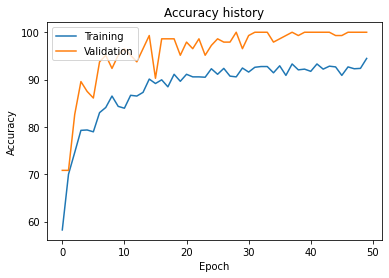

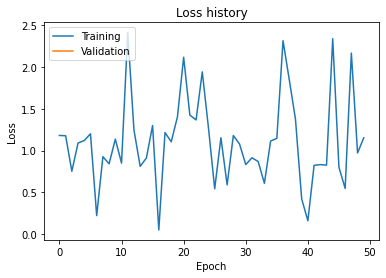

In [15]:
loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Initialize the model for this run
fine_tune = True
pretrained = True
model = ResNet50(num_classes, fine_tune, pretrained).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
contrastive_loss = ContrastiveLoss()
distance = torch.nn.MSELoss()
# Train the model
lr = learning_rate
total_step = len(lyme_train_data_loader)

for epoch in range(num_epochs):
    model.train()
    correct = 0
    correct_image_one = 0
    correct_image_two = 0
    total = 0 
    for batch_idx, data in enumerate(lyme_train_data_loader):
        [pair_image_one, pair_image_two], get_pair_label, [label_image_one, label_image_two] = data
        # Move tensors to the configured device
        pair_image_one = pair_image_one.to(device)
        pair_image_two = pair_image_two.to(device)

        label_image_one = label_image_one.to(device)
        label_image_two = label_image_two.to(device)
        get_pair_label = get_pair_label.to(device)
        
        # Forward pass of positive image
        features_image_one, output_one = model(pair_image_one)

        features_image_one, output_one = features_image_one.to(device), output_one.to(device)
        # Forward pass of negative image
        features_image_two, output_two = model(pair_image_two)
        features_image_two, output_two = features_image_two.to(device), output_two.to(device)

        predicted_one = torch.where(torch.sigmoid(output_one.data) > 0.5, 1, 0)
        predicted_two = torch.where(torch.sigmoid(output_two.data) > 0.5, 1, 0)

        # compute loss for positive image
        loss = criterion(output_one, label_image_one.float()) 
        # compute loss for negative image 
        loss += criterion(output_two, label_image_two.float()) 
        # normalize
        loss *= 0.5
        
        distance_features = distance(features_image_one, features_image_two)
        loss_features_similarity = contrastive_loss(distance_features, get_pair_label)
        
        loss += loss_features_similarity
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, batch_idx+1, total_step, loss.item()))
        total += label_image_one.size(0)
        correct_image_one += (predicted_one == label_image_one).sum().item()
        
        total += label_image_two.size(0)
        correct_image_two += (predicted_two == label_image_two).sum().item()
        
        correct = (correct_image_one + correct_image_two)
        
        
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())

    with (torch.no_grad()):
      total = 0
      correct = 0
      model.eval()
      for batch_idx, data in enumerate(lyme_validation_data_loader):
          [pair_image_one, pair_image_two], get_pair_label, [label_image_one, label_image_two] = data
          # Move tensors to the configured device
          pair_image_one = pair_image_one.to(device)
          pair_image_two = pair_image_two.to(device)

          label_image_one = label_image_one.to(device)
          label_image_two = label_image_two.to(device)
          # Forward pass of positive image
          features_image_one, output_one = model(pair_image_one)
          features_image_two, output_two = model(pair_image_two)

          features_image_one, output_one = features_image_one.to(device), output_one.to(device)
          features_image_two, output_two = features_image_two.to(device), output_two.to(device)

          predicted_one = torch.where(torch.sigmoid(output_one.data) > 0.5, 1, 0)
          predicted_two = torch.where(torch.sigmoid(output_two.data) > 0.5, 1, 0)

          total += label_image_one.size(0)
          total += label_image_two.size(0)
          correct += (predicted_one == label_image_one).sum().item()
          correct += (predicted_two == label_image_two).sum().item()
          

                    
      print('validation accuracy is: {} %'.format(100 * correct / total))
      val_acc_history.append(100 * correct / total)

#TODO: add validation

plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [35]:
with (torch.no_grad()):
      total = 0
      correct = 0
      model.eval()
      for batch_idx, data in enumerate(lyme_test_data_loader):
          pair_image_one, label_image_one = data
          # Move tensors to the configured device
          pair_image_one = pair_image_one.to(device)
          #pair_image_two = pair_image_two.to(device)

          label_image_one = label_image_one.to(device)
          #label_image_two = label_image_two.to(device)
          # Forward pass of positive image
          features_image_one, output_one = model(pair_image_one)
          #features_image_two, output_two = model(pair_image_two)

          features_image_one, output_one = features_image_one.to(device), output_one.to(device)
          #features_image_two, output_two = features_image_two.to(device), output_two.to(device)

          predicted_one = torch.where(torch.sigmoid(output_one.data) > 0.5, 1, 0)
          #predicted_two = torch.where(torch.sigmoid(output_two.data) > 0.5, 1, 0)

          total += label_image_one.size(0)
          #total += label_image_two.size(0)
          correct += (predicted_one == label_image_one).sum().item()
          #correct += (predicted_two == label_image_two).sum().item()
          

                    
      print('test accuracy is: {} %'.format(100 * correct / total))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


test accuracy is: 93.10344827586206 %
